#**Step 1: Install All the Required Packages**

In [1]:
!pip install -qqq -U git+https://github.com/huggingface/transformers.git@e03a9cc

!pip install -qqq -U git+https://github.com/huggingface/accelerate.git@c9fbb71
!pip install -qqq -U datasets
!pip install -qqq -U loralib
!pip install -qqq -U einops

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.14.15 requires transformers>=4.33.1, but you have transformers 4.30.0.dev0 which is incompatible.


In [2]:
!pip install -q -U accelerate

In [3]:
!pip install -qqq -U git+https://github.com/huggingface/peft.git@42a184f

In [4]:
!pip install -q -U trl

In [5]:
!pip install -qqq -U bitsandbytes

#**Step 2: Import All the Required Libraries**

In [6]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)

from peft import LoraConfig, PeftModel
from trl import SFTTrainer

In [ ]:
java_ds = load_dataset("JetBrains-Research/lca-bug-localization", "java")
py_ds = load_dataset("JetBrains-Research/lca-bug-localization", "py")
kt_ds = load_dataset("JetBrains-Research/lca-bug-localization", "kt")

In [ ]:
import re


# Define a function to transform the data
def transform_conversation(example):
    issue_title, issue_body, diff, changed_files = example['issue_title'], example['issue_body'], example['diff'], example['changed_files']
    
    human_text = f'Here is an issue titled "{issue_title}": {issue_body}. Changes made in order to fix this issue are:\n{diff}\nNow tell me \
    what are the buggy files?'
    assistant_text = f'Here is the list of buggy files:\n{changed_files}'
    
    reformatted = f'<s>[INST] {human_text} [/INST] {assistant_text} </s>'
    
    return {'text' : reformatted}


# Apply the transformation
kt_train = kt_ds['train'].map(transform_conversation)
java_train = java_ds['train'].map(transform_conversation)
py_train = py_ds['train'].map(transform_conversation)

kt_test = kt_ds['test'].map(transform_conversation)
java_test = java_ds['test'].map(transform_conversation)
py_test = py_ds['test'].map(transform_conversation)

kt_dev = kt_ds['dev'].map(transform_conversation)
java_dev = java_ds['dev'].map(transform_conversation)
py_dev = py_ds['dev'].map(transform_conversation)

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [10]:
from datasets import concatenate_datasets

train_data = concatenate_datasets([kt_train, java_train, py_train])
test_data = concatenate_datasets([kt_test, java_test, py_test])
train_dev = concatenate_datasets([kt_dev, java_dev, py_dev])

#**In case of Llama 2, the following prompt template is used for the chat models**

System Prompt (optional) to guide the model


User prompt (required) to give the instruction


Model Answer (required)

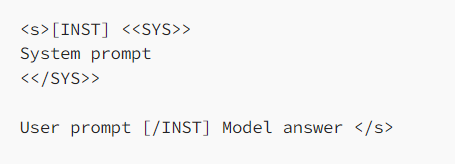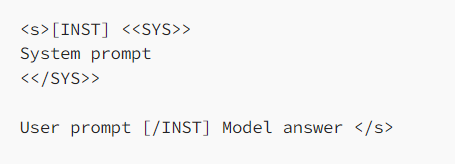

#We will reformat our instruction dataset to follow Llama 2 template.

- Orignal Dataset: https://huggingface.co/datasets/timdettmers/openassistant-guanaco

- Reformat Dataset following the Llama 2 template with 1k sample: https://huggingface.co/datasets/mlabonne/guanaco-llama2-1k

- Complete Reformat Dataset following the Llama 2 template: https://huggingface.co/datasets/mlabonne/guanaco-llama2

To know how this dataset was created, you can check this notebook.  

https://colab.research.google.com/drive/1Ad7a9zMmkxuXTOh1Z7-rNSICA4dybpM2?usp=sharing

### Note: You don’t need to follow a specific prompt template if you’re using the base Llama 2 model instead of the chat version.

#**How to fine tune Llama 2**

- Free Google Colab offers a 15GB Graphics Card (Limited Resources --> Barely enough to store Llama 2–7b’s weights)

- We also need to consider the overhead due to optimizer states, gradients, and forward activations

- Full fine-tuning is not possible here: we need parameter-efficient fine-tuning (PEFT) techniques like LoRA or QLoRA.

- To drastically reduce the VRAM usage, we must fine-tune the model in 4-bit precision, which is why we’ll use QLoRA here.

#**Step 3**

1. Load a llama-2-7b-chat-hf model (chat model)
2. Train it on the mlabonne/guanaco-llama2-1k (1,000 samples), which will produce our fine-tuned model Llama-2-7b-chat-finetune

QLoRA will use a rank of 64 with a scaling parameter of 16. We’ll load the Llama 2 model directly in 4-bit precision using the NF4 type and train it for one epoch

In [11]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"

# The instruction dataset to use
dataset_name = "mlabonne/guanaco-llama2-1k"

# Fine-tuned model name
new_model = "Llama-2-7b-chat-finetune"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = True
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 1

# Batch size per GPU for evaluation
per_device_eval_batch_size = 1

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 4

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_8bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.01

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 100

# Log every X updates steps
logging_steps = 100

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# # Load the entire model on the GPU 0
device_map = 'auto'

#**Step 4:Load everything and start the fine-tuning process**

1. First of all, we want to load the dataset we defined. Here, our dataset is already preprocessed but, usually, this is where you would reformat the prompt, filter out bad text, combine multiple datasets, etc.


2. Then, we’re configuring bitsandbytes for 4-bit quantization.


3. Next, we're loading the Llama 2 model in 4-bit precision on a GPU with the corresponding tokenizer.


4. Finally, we're loading configurations for QLoRA, regular training parameters, and passing everything to the SFTTrainer. The training can finally start!

In [12]:
# dataset = dataset.shuffle(0)[:(len(dataset)*5)//10]

In [ ]:
# Load dataset (you can process it here)
dataset = train_data

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()

In [14]:
# Save the model after training
new_model_path = "./Llama-2-7b-chat-finetune"
os.makedirs(new_model_path, exist_ok=True)

print(f"Saving the model to {new_model_path}...")
trainer.model.save_pretrained(new_model_path)
tokenizer.save_pretrained(new_model_path)
print("Model and tokenizer saved successfully.")

Saving the model to ./Llama-2-7b-chat-finetune...
Model and tokenizer saved successfully.


In [15]:
# Optionally, merge LoRA weights
print("Merging LoRA weights with the base model...")
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)

Merging LoRA weights with the base model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [16]:
# Load the fine-tuned model with LoRA weights
model = PeftModel.from_pretrained(base_model, new_model_path)
model = model.merge_and_unload()  # Merge LoRA weights into the base model

# Save the merged model for inference use
model.save_pretrained(new_model_path)
tokenizer.save_pretrained(new_model_path)
print("Merged model saved successfully.")

/opt/conda/lib/python3.10/site-packages/peft/peft_model.py:398: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adapters_weights = torch.load(


Merged model saved successfully.


In [17]:
# Optional: Run a test inference
print("Running a test inference...")
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
prompt = "What is a large language model?"
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Running a test inference...


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


<s>[INST] What is a large language model? [/INST]  A large language model (LLM) is a type of artificial intelligence (AI) model that is trained on vast amounts of text data to generate language outputs that are coherent and natural-sounding., such as text, images, and even videos. The goal of an LLM is to generate high-quality text that is similar to the training data, but not necessarily identical to it.

LLMs are typically trained using deep learning techniques, such as transformer-based architectures, on large datasets of text. The training process involves optimizing the model's parameters to minimize a loss function that measures how well the generated text matches the training data. The training process can take weeks or even months to complete, depending on the size of the dataset and the computational resources available.

There are several types of LLMs, including:

1. Generative language


#**Step 8: Push Model to Hugging Face Hub**

Our weights are merged and we reloaded the tokenizer. We can now push everything to the Hugging Face Hub to save our model.

In [18]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

In [19]:
# !huggingface-cli login

# model.push_to_hub("entbappy/Llama-2-7b-chat-finetune", check_pr=True)

# tokenizer.push_to_hub("entbappy/Llama-2-7b-chat-finetune",check_pr=True)


You can now use this model for inference by loading it like any other Llama 2 model from the Hub.